# Abstract

*A problem well stated is a problem half-solved.*

*This is your space to describe your intentions for the project, before writing a single line of code. What are you studying? What are you hoping to build? If you can't explain that clearly before you start digging into the data, you're going to have a hard time planning where to go with this.*

# Obtain the Data

*Describe your data sources here and explain why they are relevant to the problem you are trying to solve.*

*Your code should download the data and save it in data/raw. If you've got the data from an offline source, describe where it came from and what the files look like. Don't do anything to the raw data files just yet; that comes in the next step.*

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [12]:
## %%writefile ../src/data/make_dataset.py

# Imports
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import json


# Parameters
drizly_drinks_path = '../data/raw/drizly_drinks.pickle'
difford_drink_path = '../data/raw/difford_drink_list.pkl'


def get_soup(url):
    """
    Given url, return soup. Return None if host unresponsive
    """
    soup = None
    r = requests.get(url, timeout=5)
    if r.ok:
        soup = BeautifulSoup(r.content, 'html.parser')
    return soup


def parse_tables(soup):
    df0, df1 = pd.read_html(soup.prettify())
    cocktail = {
        'glass': df0.iloc[0, 0],
        'recipe': df0.iloc[1:, :].rename(columns={0: 'Qty', 1: 'Units', 2: 'Ingredient'}),
        'ingredients': {k: '' for k in df0.iloc[1:, 2]}
    }

    for i, row in df1.iterrows():
        if i % 2:
            continue
        try:
            next_value = df1.iloc[i + 1, 0]
        except:
            next_value = np.nan
        if 'How to make' in row[0]:
            cocktail.update({'instructions': next_value})
        elif 'Garnish' in row[0]:
            cocktail.update({'garnish': next_value})
        elif 'Comment' in row[0]:
            cocktail.update({'description': next_value})
        elif 'Nutrition' in row[0]:
            cocktail.update({'nutrition': next_value})
        elif 'Variant' in row[0]:
            cocktail.update({'variant': next_value})
        elif 'About' in row[0]:
            cocktail.update({'about': next_value})
        else:
            cocktail.update({'other': next_value})
    return cocktail


def get_difford_cocktail_data():
    """
    """
    drink_list = load_from(difford_drink_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
#         print(f'Getting {drink}.', '\r', end='')
        
        num_drinks -= 1
        f = [drink, 'description', 'ingredients', 'name', 'garnish', 'about', 
             'img', 'recipe']
        if len(set(f) & set(stats.keys())) >= len(f) - 3:
            print(f'Drinks remaining: {num_drinks}. Skipped {drink}.', 
                  '\r', end='')
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            print(f'Failed to get {drink} soup.')
            continue

        # Duplicate name in dict
        stats.update({'name': drink})
        
        # Get ingredient names and links
        ingredients = soup.findAll('table')[0]
        for row in ingredients.findAll('tr'):
            for cell in row.findAll('td'):
                link = cell.find('a')
                if link:
                    name = link.text.replace('\n', '').replace('\xa0', ' ').strip()
                    slug = link['href']
                    url = f'https://www.diffordsguide.com{slug}'
                    stats.update({'ingredients': {'url': url}})
        
        # Get image source
        img_class = 'cocktails_image_wrapper'
        image = soup.find('div', class_=img_class)
        try:
            stats.update({'img': image.img['src']})
        except:
            stats.update({'img': np.nan})
        
        # Parse tables
        tables = parse_tables(soup)
        stats.update({k: v for k, v in tables.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', '\r', end='')
        save_to(drink_list, difford_drink_path, verbose=False)
    return drink_list


def get_drinks_from_page(soup, drink_list):
    tag = 'div'
    tag_class = 'box-link'
    tags = soup.findAll(tag, attrs={'class': tag_class})
#     print(f'Found {len(tags)} drinks.')
    for div in tags:
        l = div.find('a')
        if l:
            t = div.find('h3')
            name = t.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://www.diffordsguide.com{slug}'
            drink_list[name] = {'url': url}
    return drink_list


def get_next_page(page=1):
    offset = 40 * (page - 1)
    url = 'https://www.diffordsguide.com/cocktails/search?' \
        '&rating=3%2C3.5%2C4%2C4.5%2C5%2C5.5&sort=name&limit=40' \
        f'&offset={offset}'
    soup = get_soup(url)
    try:
        res = soup.find('div', 
                        attrs={'class': 'global_search_info hairline_bottom'})
        return soup
    except:
        return ''

    
@load_or_make(difford_drink_path, overwrite='n')
def get_cocktail_list():
    drink_list = {}
    page = 1
    soup = get_next_page(page)
    while soup:
        drink_list = get_drinks_from_page(soup, drink_list)
        print(f'Scraped page {page}. Now have {len(drink_list)} drinks.',
             '\r', end='')
        page += 1
        if page > 115:
            break
        soup = get_next_page(page)
    save_to(drink_list, difford_drink_path)
    return drink_list


def get_difford_cocktails():
    drink_list = get_cocktail_list()
    drink_list = get_difford_cocktail_data()
    return drink_list


def get_ingredients(soup):
    """
    """
    d = soup.find_all('div', attrs={'data-integration-name':'react-component'})
    info = json.loads(d[1].get('data-payload'))
    productIds = info['props']['productIDs']

    base = 'https://drizly.com/async_catalog_fetch?category_overrides'
    ids = '&product_ids[]='.join(map(str, productIds))
    req = f'{base}&product_ids[]={ids}&product_overrides'
    r = requests.get(req)
    if not r.ok:
        return {}
    products = r.json()
    
    ingr_path = '../data/raw/ingredients.pickle'
    if file_exists(ingr_path):
        ingredients = load_from(ingr_path)
    else:
        ingredients = {}
    drink_ingrs = {}
        
    for p in products['catalogItems']:
        name = p['name']
        attrs = {
            'description': p['description'],
            'url': f"https://drizly.com/{p['click_url']}", 
            'categories': p['category_names']}
        ingredients.setdefault(name, {})
        ingredients[name].update(attrs)
        drink_ingrs[name] = attrs
    save_to(ingredients, ingr_path)
    return drink_ingrs


def scrape_text(soup, stats, field, tag, tag_class):
    tags = soup.findAll(tag, attrs={'class': tag_class})
    cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
    text = [cleaned(t) for t in tags]
    stats.update({field: text})
    return
        

def get_cocktail_data():
    """
    """
    drink_list = load_from(drizly_drinks_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
        num_drinks -= 1
        f = ['description', 'recipeIngredient', 'name', 'recipeInstructions']
        if len(set(f) & set(stats.keys())) == len(f):
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            continue

        # Get fields
        data = json.loads(soup.find('script', type='application/ld+json').text)
        stats.update({key: data[key] for key in f})
        
        items = [
            ('tags', 'li', 'Recipe__tag'),
            ('stats', 'li', 'stat'),
            ('tools', 'li', 'Tools__tool')
        ]
        
        # Get items
        for item in items:
            scrape_text(soup, stats, *item)
            
        # Get ingredient data
        drink_ingrs = get_ingredients(soup)
        stats.update({k: v for k, v in drink_ingrs.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', 
              '\r', end='')
        save_to(drink_list, drizly_drinks_path)
    return drink_list


def get_drink_list(verbose=False):
    """
    """
    url = "https://drizly.com/recipes#all-recipes"
    soup = get_soup(url)
    link_class = "recipe-link"
    data = soup.findAll('li',attrs={'class': link_class})
    drink_list = {}
    for li in data:
        l = li.find('a')
        if l:
            name = l.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://drizly.com{slug}'
            drink_list[name] = {'url': url}
    if verbose:
        for drink in drink_list.values():
            print(drink['url'])
    save_to(drink_list, drizly_drinks_path)
    return drink_list


@load_or_make(drizly_drinks_path, overwrite='y')
def scrape_drizly():
    """
    """
    get_drink_list()
    drizly_drinks = get_cocktail_data()
    print(f'Collected data on {len(drizly_drinks)} cocktails from Drizly')
    return drizly_drinks

    
def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    scrape_drizly()
    # download_dataset_1(url)
    # download_dataset_2(url)
    # save_dataset_1('data/raw', filename)
    # save_dataset_2('data/raw', filename)
    drink_list = load_from(drizly_drinks_path)
    return drink_list

In [185]:
drink_list = run()

Are you sure you want to overwrite ../data/raw/drizly_drinks.pickle? y/n: y
Collected data on 671 cocktails from Drizlym Float. ioned. n. d Vodka.  . 


In [186]:
drink_list

{'Absolut Pears Mule': {'url': 'https://drizly.com/absolut-pears-mule/r-e8ac3756cf8d8709',
  'description': '<p>Mellow out your mule with the subtle sweetness of pears. The Absolut Pears Mule: sit back, sip, and repeat.</p>',
  'recipeIngredient': ['1 part Absolut Pear\n',
   '3 parts Ginger Beer\n',
   'Splash Fresh Lime Juice\n'],
  'name': 'Absolut Pears Mule',
  'recipeInstructions': 'Pour Absolut, ginger beer, and lime juice into a mule mug filled with ice cubes. Garnish with a slice of Pear\n',
  'tags': ['vodka', 'sweet'],
  'stats': ['Level: Easy', 'Prep: 3 min'],
  'tools': ['Ice cube tray', 'Swizzle stick', 'Citrus juicer'],
  'Goslings Ginger Beer': {'description': 'We didn’t steer you wrong on the whole shorts thing. Trust us on this one, too. We spent over a year to achieve the ideal balance of sweetness and spiciness and matching it to the flavour profile of our award-winning Black Seal Rum.    Only our Black Seal Rum makes a Dark ‘n Stormy genuine. Only our Ginger Beer m

## Scraping Spruce Eats

In [2]:
from bs4 import BeautifulSoup
import requests

### Get Drink List

In [40]:
def get_spruce_drinks(verbose=False):
    """
    """
    url = "https://www.thespruceeats.com/a-to-z-cocktail-recipes-3962886"
    soup = get_soup(url)
    link_class = "comp text-passage ordered-list__content-description mntl-sc-block mntl-sc-block-html"
    data = soup.findAll('div',attrs={'class': link_class})
    spruce_drinks = {}
    for div in data:
        links = div.findAll('li')
        for a in links:
            l = a.find('a')
            if l:
                name = l.text
                spruce_drinks[name] = {'url': l['href']}
    if verbose:
        for drink in spruce_drinks.values():
            print(drink['url'])
    return spruce_drinks

In [41]:
spruce_drinks = get_spruce_drinks()
spruce_drinks

{'Adult Hot Chocolate': {'url': 'https://www.thespruceeats.com/adult-hot-chocolate-recipe-759570'},
 'Alabama Slammer': {'url': 'https://www.thespruceeats.com/alabama-slammer-shooter-recipe-759572'},
 'Alexander': {'url': 'https://www.thespruceeats.com/brandy-alexander-cocktail-recipe-759278'},
 'Americano': {'url': 'https://www.thespruceeats.com/americano-cocktail-recipe-759279'},
 'Anejo Highball': {'url': 'https://www.thespruceeats.com/dale-degroffs-anejo-highball-cocktail-recipe-760491'},
 'Aperol Spritz': {'url': 'https://www.thespruceeats.com/aperol-spritz-cocktail-recipe-759259'},
 'Apple Margarita': {'url': 'https://www.thespruceeats.com/apple-margarita-recipe-759577'},
 'Apple Martini': {'url': 'https://www.thespruceeats.com/apple-martini-recipe-759579'},
 'Aviation Cocktail': {'url': 'https://www.thespruceeats.com/aviation-cocktail-recipe-760055'},
 'After Five': {'url': 'https://www.thespruceeats.com/girl-scout-cookie-shots-and-drinks-759571'},
 'Apocalypse Now': {'url': 'ht

In [38]:
link_class = "comp text-passage ordered-list__content-description mntl-sc-block mntl-sc-block-html"
data = soup.findAll('div',attrs={'class': link_class})
spruce_drinks = {}
for div in data:
    links = div.findAll('li')
    for a in links:
        l = a.find('a')
        if l:
            name = l.text
            spruce_drinks[name] = {'url': l['href']}
for drink in spruce_drinks.values():
    print(drink['url'])

https://www.thespruceeats.com/adult-hot-chocolate-recipe-759570
https://www.thespruceeats.com/alabama-slammer-shooter-recipe-759572
https://www.thespruceeats.com/brandy-alexander-cocktail-recipe-759278
https://www.thespruceeats.com/americano-cocktail-recipe-759279
https://www.thespruceeats.com/dale-degroffs-anejo-highball-cocktail-recipe-760491
https://www.thespruceeats.com/aperol-spritz-cocktail-recipe-759259
https://www.thespruceeats.com/apple-margarita-recipe-759577
https://www.thespruceeats.com/apple-martini-recipe-759579
https://www.thespruceeats.com/aviation-cocktail-recipe-760055
https://www.thespruceeats.com/girl-scout-cookie-shots-and-drinks-759571
https://www.thespruceeats.com/apocalypse-now-shooter-759576
https://www.thespruceeats.com/arnold-palmer-mocktail-recipe-760357
https://www.thespruceeats.com/autumnal-temptations-recipe-non-alcoholic-760341
https://www.thespruceeats.com/50-50-gin-martini-recipe-759550
https://www.thespruceeats.com/spring-cocktail-recipes-759873
https

In [116]:
len(spruce_drinks)

936

### Get Drink Text

In [17]:
manhattan = spruce_drinks['Manhattan']
r = requests.get(manhattan['url'], timeout=5)
manhattan_soup = BeautifulSoup(r.content, 'html.parser')

In [23]:
text_class = "comp mntl-sc-block mntl-sc-block-html"
data = manhattan_soup.findAll('div',attrs={'class': text_class})
manhattan_text = {}
for div in data:
    text = div.findAll('p')
    for t in text:
        print(t.text)

One of the finest and oldest cocktails, the Manhattan is truly a classic cocktail. It is a simple drink recipe that requires just a few ingredients. You can choose between rye whiskey and bourbon, though some drinkers still prefer a smooth Canadian whisky. There is no doubt, however, that this is one of the essential whiskey cocktails that everyone should know.
As with the gin martini, there are many ways that you can adapt the Manhattan to your personal taste. It has also inspired countless variations, but before you give those a taste, it's best to start off with the original. Even though it is an easy cocktail, there are a number of choices to be made and it all begins with deciding which whiskey to pour.
No matter how you mix up your Manhattan, you will find that it's an ideal drink for any occasion. It is perfect for a dinner party and pairs nicely with a great variety of foods. It's also a fantastic drink for a casual night with friends.
Gather the ingredients.
Pour the ingredien

### Get Drink Ingredients

In [31]:
li_class = "simple-list__item js-checkbox-trigger ingredient"
data = manhattan_soup.findAll('li',attrs={'class': li_class})
ingredients = [li.text.replace('\n', '').replace('\xa0', ' ') for li in data]
ingredients

['2 ounces rye whiskey, bourbon, or Canadian whiskey',
 '1 ounce sweet vermouth',
 '2 to 3 dashes Angostura Bitters',
 'Garnish: cherry']

## Drizly

### Get Drink List

In [2]:
def get_drizly_drink_list(verbose=False):
    """
    """
    url = "https://drizly.com/recipes#all-recipes"
    soup = get_soup(url)
    link_class = "recipe-link"
    data = soup.findAll('li', attrs={'class': link_class})
    drizly_drink_list = {}
    for li in data:
        l = li.find('a')
        if l:
            name = l.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://drizly.com{slug}'
            drizly_drink_list[name] = {'url': url}
    if verbose:
        for drink in drizly_drink_list.values():
            print(drink['url'])
    return drizly_drink_list

In [34]:
drink_list = get_drink_list()
drink_list

Are you sure you want to overwrite ../data/raw/drizly_drink_list.pickle? y/n: n


{'Absolut Pears Mule': {'url': 'https://drizly.com/absolut-pears-mule/r-e8ac3756cf8d8709'},
 'Adults Only-Frozen Hot Chocolate': {'url': 'https://drizly.com/adults-only-frozen-hot-chocolate/r-0779721198d731dd'},
 'Alabama Slammer': {'url': 'https://drizly.com/alabama-slammer/r-f0ed6be5a64cf337'},
 'All American Lemonade': {'url': 'https://drizly.com/all-american-lemonade/r-0b86893ab36abcc1'},
 'Amaretto Sour': {'url': 'https://drizly.com/amaretto-sour/r-481d961d37ae7dcb'},
 'American Mule': {'url': 'https://drizly.com/american-mule/r-dd6a2c48a6594cdc'},
 'American Sour': {'url': 'https://drizly.com/american-sour/r-9eb324bdf7f70cdb'},
 'Americano': {'url': 'https://drizly.com/americano/r-edc93c907ca56ce6'},
 'Americran Harvest': {'url': 'https://drizly.com/americran-harvest/r-96a93beb550d95bb'},
 'Amethyst Anchor': {'url': 'https://drizly.com/Amethyst_Anchor/r-18c10afe0f12f825'},
 'Anejo Rum Old-Fashioned': {'url': 'https://drizly.com/anejo-rum-old-fashioned/r-beb0675a6a7d6241'},
 'Anej

### Get Drink Text

## Imbibe and PDT Cocktails

In [411]:
url = 'https://docs.google.com/spreadsheets/d/1W59zl7F534rHhRhzxxAH0EMqbe4H7qGz646srCpRnXw/pub?single=true&gid=0&output=html'
cocktails = pd.read_html(
    url, 
    header=1, index_col=1, skiprows=[2], 
    encoding='UTF-8'
)[0]
cocktails = cocktails.drop(['1', 'Picture', 'Proof'], axis=1)
cocktails.head()

,Ingredients,Preparation,Source,Comments,Overall rating
Name,,,,,
Americano Highball,1.5 oz. Carpano Antica Sweet Vermouth1.5 oz. C...,Build in a chilled Collins glassAdd ice and to...,"PDT, Meehan (Originally Leurs Cocktails Par An...",NaN,Very good
Applejack Rabbit,2 oz. Laird’s Bonded Apple Brandy.75 oz. Lemon...,Shake with ice and strain into a chilled coupe...,"Meehan (Originally Judge Jr., Here’s How, 1927)",Can use applejack instead of bonded apple brandy?,Unknown
Aruba,2 oz gin¾ oz fresh lemon juice½ oz Cointreau½ ...,Add all ingredients to a mixing tin and shake ...,"SmallHandFoods.com, originally Trader Vic's, O...",NaN,Good
Bensonhurst,1¾ oz rye whiskey⅔ oz dry vermouth1 bar-spoon ...,Stir over ice then strain in to a cocktail gla...,http://ohgo.sh/archive/amaro-cynar-negroni-var...,Good way to highlight cynar,Good
Berlioni,1.5 oz. Tanqueray Gin.75 oz. Cynar.5 oz. Noill...,Stir with ice and strain into a chilled rocks ...,"PDT, Meehan (Originally —Gonçalo de Sousa Mont...",Good way to use up some cynar - it's quite pro...,Good


In [409]:
def get_ingredients(soup):
    """
    """
    d = soup.find_all('div', attrs={'data-integration-name':'react-component'})
    info = json.loads(d[1].get('data-payload'))
    productIds = info['props']['productIDs']

    base = 'https://drizly.com/async_catalog_fetch?category_overrides'
    ids = '&product_ids[]='.join(map(str, productIds))
    req = f'{base}&product_ids[]={ids}&product_overrides'
    r = requests.get(req)
    if not r.ok:
        return {}
    products = r.json()
    
    ingr_path = '../data/raw/ingredients.pickle'
    if file_exists(ingr_path):
        ingredients = load_from(ingr_path)
    else:
        ingredients = {}
    drink_ingrs = {}
        
    for p in products['catalogItems']:
        name = p['name']
        attrs = {
            'description': p['description'],
            'url': f"https://drizly.com/{p['click_url']}", 
            'categories': p['category_names']}
        ingredients.setdefault(name, {})
        ingredients[name].update(attrs)
        drink_ingrs[name] = attrs
    save_to(ingredients, ingr_path)
    return drink_ingrs


def get_cocktail_data():
    """
    """
    drink_list = load_from(drizly_drinks_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
        num_drinks -= 1
        f = ['description', 'recipeIngredient', 'name', 'recipeInstructions']
        if len(set(f) & set(stats.keys())) == len(f):
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            continue

        # Get fields
        data = json.loads(soup.find('script', type='application/ld+json').text)
        stats.update({key: data[key] for key in f})

        def scrape_text(field, tag, tag_class):
            tags = soup.findAll(tag, attrs={'class': tag_class})
            cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
            text = [cleaned(t) for t in tags]
            stats.update({field: text})
            return
        
        items = [
            ('tags', 'li', 'Recipe__tag'),
            ('stats', 'li', 'stat'),
            ('tools', 'li', 'Tools__tool')
        ]
        
        # Get items
        for item in items:
            scrape_text(*item)
            
        # Get ingredient data
        drink_ingrs = get_ingredients(soup)
        stats.update({k: v for k, v in drink_ingrs.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', 
              '\r', end='')
        save_to(drink_list, drizly_drinks_path)
    return drink_list


def get_drink_list(verbose=False):
    """
    """
    url = "https://drizly.com/recipes#all-recipes"
    soup = get_soup(url)
    link_class = "recipe-link"
    data = soup.findAll('li',attrs={'class': link_class})
    drink_list = {}
    for li in data:
        l = li.find('a')
        if l:
            name = l.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://drizly.com{slug}'
            drink_list[name] = {'url': url}
    if verbose:
        for drink in drink_list.values():
            print(drink['url'])
    save_to(drink_list, drizly_drinks_path)
    return drink_list

'1.5 oz. Carpano Antica Sweet Vermouth1.5 oz. Campari'

## Kindred Cocktails

In [9]:
url = 'https://kindredcocktails.com/info/ingredients'
soup = get_soup(url)
soup.text

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIngredients | Kindred Cocktails\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<!--//--><![CDATA[//><!--\n(function(i,s,o,g,r,a,m){i["GoogleAnalyticsObject"]=r;i[r]=i[r]||function(){(i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)})(window,document,"script","https://www.google-analytics.com/analytics.js","ga");ga("create", "UA-1495290-2", {"cookieDomain":"auto"});ga("send", "pageview");\n//--><!]]>\n\n\n\n\n<!--//--><![CDATA[//><!--\njQuery.extend(Drupal.settings, {"basePath":"\\/","pathPrefix":"","ajaxPageState":{"theme":"kindredcocktails","theme_token":"fMVWT_GPWTl4hmAIMHmNsVmmvNzPlzlcjCL5QLie2S0","js":{"misc\\/jquery.js":1,"misc\\/jquery-extend-3.4.0.js":1,"misc\\/jquery.once.js":1,"misc\\/drupal.js":1,"misc\\/jquery.cookie.js":1,"misc\\/jquery.form.js":1,"misc\\/ajax.js":1,"sites\\/kindredcocktails.com\\/modules\\/cocktail\\/cocktail.js":1,"sites\\/all\\

## Difford's Guide

### Get Cocktail List

In [406]:
url = 'https://www.diffordsguide.com/cocktails/search?force_limit=20&rating=3%2C3.5%2C4%2C4.5%2C5%2C5.5&sort=rating&limit=40&offset=0&force_limit=20'
soup = get_soup(url)
soup.prettify()

'<!DOCTYPE html>\n<html lang="en">\n <head>\n  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>\n  <meta content="width=device-width" name="viewport"/>\n  <title>\n   Search cocktails and cocktail Recipes with ratings 3,3.5,4,4.5,5,5.5\n  </title>\n  <meta content="From Left Bank Martini to Dry Martini (Montgomery\'s 15:1 ratio), there\'s all sorts of 3 to 3.5 star rated delicious cocktails and mixed drinks you can whip up on Difford\'s Guide" name="description"/>\n  <meta content="Cocktails with ratings 3,3.5,4,4.5,5,5.5 - A searchable library of over 3,000 easy to follow recipes, including the Mojito, Margarita, Old Fashioned and Daiquiri, and thousands of other vodka cocktails, gin cocktails, rum cocktails, champagne cocktails, brandy cocktails. Search homepage." name="keywords"/>\n  <link href="https://www.diffordsguide.com/en-au/cocktails/search?force_limit=20&amp;rating=3%2C3.5%2C4%2C4.5%2C5%2C5.5&amp;sort=rating&amp;limit=40&amp;offset=0&amp;force_limit=20" h

### Get All Difford Data

In [7]:
difford_drink_path = '../data/raw/difford_drink_list.pkl'


def get_difford_ingredients(soup):
    """
    """
    return drink_ingrs


def parse_tables(soup):
    df0, df1 = pd.read_html(soup.prettify())
    cocktail = {
        'glass': df0.iloc[0, 0],
        'recipe': df0.iloc[1:, :].rename(columns={0: 'Qty', 1: 'Units', 2: 'Ingredient'}),
        'ingredients': {k: '' for k in df0.iloc[1:, 2]}
    }

    for i, row in df1.iterrows():
        if i % 2:
            continue
        try:
            next_value = df1.iloc[i + 1, 0]
        except:
            next_value = np.nan
        if 'How to make' in row[0]:
            cocktail.update({'instructions': next_value})
        elif 'Garnish' in row[0]:
            cocktail.update({'garnish': next_value})
        elif 'Comment' in row[0]:
            cocktail.update({'description': next_value})
        elif 'Nutrition' in row[0]:
            cocktail.update({'nutrition': next_value})
        elif 'Variant' in row[0]:
            cocktail.update({'variant': next_value})
        elif 'About' in row[0]:
            cocktail.update({'about': next_value})
        else:
            cocktail.update({'other': next_value})
    return cocktail


def get_difford_cocktail_data():
    """
    """
    drink_list = load_from(difford_drink_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
#         print(f'Getting {drink}.', '\r', end='')
        
        num_drinks -= 1
        f = [drink, 'description', 'ingredients', 'name', 'garnish', 'about', 
             'img', 'recipe']
        if len(set(f) & set(stats.keys())) >= len(f) - 3:
            print(f'Drinks remaining: {num_drinks}. Skipped {drink}.', 
                  '\r', end='')
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            print(f'Failed to get {drink} soup.')
            continue

        # Duplicate name in dict
        stats.update({'name': drink})
        
        # Get ingredient names and links
        ingredients = soup.findAll('table')[0]
        for row in ingredients.findAll('tr'):
            for cell in row.findAll('td'):
                link = cell.find('a')
                if link:
                    name = link.text.replace('\n', '').replace('\xa0', ' ').strip()
                    slug = link['href']
                    url = f'https://www.diffordsguide.com{slug}'
                    stats.update({'ingredients': {'url': url}})
        
        # Get image source
        img_class = 'cocktails_image_wrapper'
        image = soup.find('div', class_=img_class)
        try:
            stats.update({'img': image.img['src']})
        except:
            stats.update({'img': np.nan})
        
        # Parse tables
        tables = parse_tables(soup)
        stats.update({k: v for k, v in tables.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', '\r', end='')
        save_to(drink_list, difford_drink_path, verbose=False)
    return drink_list


def get_drinks_from_page(soup, drink_list):
    tag = 'div'
    tag_class = 'box-link'
    tags = soup.findAll(tag, attrs={'class': tag_class})
#     print(f'Found {len(tags)} drinks.')
    for div in tags:
        l = div.find('a')
        if l:
            t = div.find('h3')
            name = t.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://www.diffordsguide.com{slug}'
            drink_list[name] = {'url': url}
    return drink_list


def get_next_page(page=1):
    offset = 40 * (page - 1)
    url = 'https://www.diffordsguide.com/cocktails/search?' \
        '&rating=3%2C3.5%2C4%2C4.5%2C5%2C5.5&sort=name&limit=40' \
        f'&offset={offset}'
    soup = get_soup(url)
    try:
        res = soup.find('div', 
                        attrs={'class': 'global_search_info hairline_bottom'})
        return soup
    except:
        return ''

    
@load_or_make(difford_drink_path, overwrite='n')
def get_cocktail_list():
    drink_list = {}
    page = 1
    soup = get_next_page(page)
    while soup:
        drink_list = get_drinks_from_page(soup, drink_list)
        print(f'Scraped page {page}. Now have {len(drink_list)} drinks.',
             '\r', end='')
        page += 1
        if page > 115:
            break
        soup = get_next_page(page)
    save_to(drink_list, difford_drink_path)
    return drink_list


def get_difford_cocktails():
    drink_list = get_cocktail_list()
    drink_list = get_difford_cocktail_data()
    return drink_list

In [8]:
drink_list = get_difford_cocktails()
len(drink_list)

Saved file to ../data/raw/difford_drink_list.pkl
Loaded file from ../data/raw/difford_drink_list.pkl


4114

In [10]:
drink_list = load_from(difford_drink_path)
drink_list["Zuzu's Petals cocktail"]

Loaded file from ../data/raw/difford_drink_list.pkl


{'url': 'https://www.diffordsguide.com/cocktails/recipe/3589/zuzus-petals-cocktail',
 'name': "Zuzu's Petals cocktail",
 'ingredients': {'Bison grass vodka': '',
  'Suze gentian liqueur': '',
  'St-Germain Elderflower Liqueur': '',
  'Freshly squeezed lime juice': '',
  'Luxardo Maraschino Originale Liqueur': '',
  'Giffard Sugar Cane Syrup (Sirop Sucre de Canne)': '',
  'Fee Brothers Celery Bitters': ''},
 'img': 'https://cdn.diffords.com/contrib/stock-images/2015/9/15/20159bf715af71e5c87aecc6d33a9b62d0a2.jpg',
 'glass': 'Serve in  a  Coupe glass  ...',
 'recipe':   Qty  Units                                       Ingredient
 1  1½  fl oz                                Bison grass vodka
 2   ½  fl oz                             Suze gentian liqueur
 3   ½  fl oz                   St-Germain Elderflower Liqueur
 4   ½  fl oz                      Freshly squeezed lime juice
 5   1  fl oz             Luxardo Maraschino Originale Liqueur
 6   ¼  fl oz  Giffard Sugar Cane Syrup (Sirop Sucr

In [11]:
# Count drinks that have been scraped
sum(['description' in drink_list[k].keys() for k in drink_list.keys()])

4060

In [13]:
'name' in drink_list['Whiskey Squirt'].keys()

False

In [17]:
drink_list['Maurice Cocktail']

{'url': 'https://www.diffordsguide.com/cocktails/recipe/1271/maurice-cocktail',
 'name': 'Maurice Cocktail',
 'ingredients': {'Rutte Dry Gin': '',
  'La Fée Parisienne Absinthe Superieure': '',
  'Noilly Prat Extra Dry Vermouth': '',
  'Martini Rosso sweet vermouth': '',
  'Freshly squeezed orange juice': ''},
 'img': 'https://cdn.diffords.com/contrib/stock-images/2016/12/13/2016bae3f766aefd2922540491f05f8529b9.jpg',
 'glass': 'Serve in  a  Martini glass  ...',
 'recipe':   Qty  Units                             Ingredient
 1  1½  fl oz                          Rutte Dry Gin
 2   ¼  fl oz  La Fée Parisienne Absinthe Superieure
 3   ¾  fl oz         Noilly Prat Extra Dry Vermouth
 4   ¾  fl oz           Martini Rosso sweet vermouth
 5   ¾  fl oz          Freshly squeezed orange juice,
 'instructions': 'SHAKE all ingredients with ice and fine strain into chilled glass.',
 'garnish': 'Orange zest twist',
 'description': 'A Bronx Cocktail with the addition of an aromatic burst of absinthe 

### Get Cocktail data

In [458]:
url = 'https://www.diffordsguide.com/cocktails/recipe/611/daiquiri-no1-natural-diffords-1032-recipe'
soup = get_soup(url)
soup.prettify()

'<!DOCTYPE html>\n<html lang="en">\n <head>\n  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>\n  <meta content="width=device-width" name="viewport"/>\n  <title>\n   Daiquiri No.1 Natural (Difford\'s 10:3:2 Recipe)\n  </title>\n  <meta content="to make a daiquiri no.1 natural (difford\'s 10:3:2 recipe) use bacardi carta blanca superior white rum (37.5%), freshly squeezed lime juice, powdered sugar, chilled" name="description"/>\n  <meta content="daiquiri no.1 natural (difford\'s 10:3:2 recipe), bacardi carta blanca superior white rum (37.5%), freshly squeezed lime juice, powdered sugar, chilled water, difford\'s daiquiri bitters by bob\'s bitters, coupe glass, daiquiri cocktail - history &amp; story of its creation, cocktail shakers &amp; how to shake a cocktail, how to strain a cocktail, classic daiquiri, natural daiquiri" name="keywords"/>\n  <link href="https://www.diffordsguide.com/en-au/cocktails/recipe/611/daiquiri-no1-natural-diffords-1032-recipe" hreflang="

In [528]:
def scrape_difford_text(soup, stats, tag, tag_value):
    tags = soup.findAll(tag, attrs={'class': tag_value})
    print(tags)
    text = [t for t in tags]
    print(text)
#     stats.update({field: text})
    return

stats = {}
fields = ['recipeInstructions', 'description']
scrape_difford_text(soup, stats, 'table', 'global_default_content_table review')

[<table class="global_default_content_table review">
<tr><td><h2 class="review__heading edit-box" data-phrase-id="42">How to make:</h2></td></tr>
<tr><td><p class="review__text" itemprop="recipeInstructions">Cut zest from your lime prior to squeezing for juice. SHAKE all ingredients with ice and fine strain into chilled glass.</p></td></tr>
<tr><td><h3 class="review__heading edit-box" data-phrase-id="43">Garnish:</h3></td></tr>
<tr><td><p class="review__text">Lime zest twist (discarded) &amp; lime wedge on rim</p></td></tr>
<tr><td><h2 class="review__heading edit-box" data-phrase-id="45">Comment:</h2></td></tr>
<br/> <br/> <br/> </p></td></tr>
<tr><td><h2 class="review__heading edit-box" data-phrase-id="508, 509">Nutrition:</h2></td></tr>
<tr><td><p class="review__text">
										There are approximately 169 calories in one serving of Daiquiri No.1 Natural (Difford's 10:3:2 recipe).
									</p></td></tr>
</table>]
[<table class="global_default_content_table review">
<tr><td><h2 class

In [546]:
pd.read_html(soup.find('table').prettify())

[                               0                              1  \
 0  Serve in  a  Coupe glass  ...  Serve in  a  Coupe glass  ...   
 1                       1&frac23                          fl oz   
 2                              ½                          fl oz   
 3                              2                          spoon   
 4                              ⅓                          fl oz   
 5                              4                           drop   
 
                                                    2  
 0                      Serve in  a  Coupe glass  ...  
 1    Bacardi Carta Blanca Superior White Rum (37.5%)  
 2                        Freshly squeezed lime juice  
 3  Powdered sugar (or use 5ml of 2:1 sugar syrup ...  
 4                                      Chilled water  
 5  Difford's Daiquiri Bitters by Bob's Bitters (o...  ]

In [639]:
cocktail = {}
df0, df1 = pd.read_html(soup.prettify())
# display(df0, df1)

cocktail = {
    'glass': df0.iloc[0, 0],
    'recipe': df0.iloc[1:, :].rename(columns={0: 'Qty', 1: 'Units', 2: 'Ingredient'}),
    'ingredients': {k: '' for k in df0.iloc[1:, 2]}
}

for i, row in df1.iterrows():
    if i % 2:
        continue
    next_value = df1.iloc[i + 1, 0]
    if 'How to make' in row[0]:
        cocktail.update({'instructions': next_value})
    elif 'Garnish' in row[0]:
        cocktail.update({'garnish': next_value})
    elif 'Comment' in row[0]:
        cocktail.update({'description': next_value})
    elif 'Nutrition' in row[0]:
        cocktail.update({'nutrition': next_value})
    elif 'Variant' in row[0]:
        cocktail.update({'variant': next_value})
    elif 'About' in row[0]:
        cocktail.update({'about': next_value})
    else:
        cocktail.update({'other': next_value})

ingredients = soup.findAll('table')[0]
for row in ingredients.findAll('tr'):
    for cell in row.findAll('td'):
        link = cell.find('a')
        if link:
            name = link.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = link['href']
            url = f'https://www.diffordsguide.com{slug}'
            cocktail['ingredients'][name] = {'url': url}

img_class = 'cocktails_image_wrapper'
image = soup.find('div', class_=img_class)
cocktail['img'] = image.img['src']

print(pprint(cocktail))

{'description': 'Crisp, light and refreshing. Delicately simple yet with '
                'perfectly balanced complexity of flavours.',
 'garnish': 'Lime zest twist (discarded) & lime wedge on rim',
 'glass': 'Serve in  a  Coupe glass  ...',
 'img': 'https://cdn.diffords.com/contrib/stock-images/2015/7/44/20158559c8ab2ea1ad789a9069b3eb38f916.jpg',
 'ingredients': {'Bacardi Carta Blanca Superior White Rum (37.5%)': {'url': 'https://www.diffordsguide.com/beer-wine-spirits/525/bacardi-carta-blanca-light-rum'},
                 'Chilled water': '',
                 'Coupe glass': {'url': 'https://www.diffordsguide.com/encyclopedia/329/cocktails/cocktail-glassware'},
                 "Difford's Daiquiri Bitters by Bob's Bitters (optional)": {'url': 'https://www.diffordsguide.com/beer-wine-spirits/3134/diffords-daiquiri-bitters'},
                 'Freshly squeezed lime juice': '',
                 'Powdered sugar (or use 5ml of 2:1 sugar syrup per spoon)': ''},
 'instructions': 'Cut zest f

In [411]:
def scrape_text(soup, stats, field, tag, tag_class):
    tags = soup.findAll(tag, attrs={'class': tag_class})
    cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
    text = [cleaned(t) for t in tags]
    stats.update({field: text})
    return


def get_cocktail_data():
    """
    """
    drink_list = load_from(drizly_drinks_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
        num_drinks -= 1
        f = ['description', 'recipeIngredient', 'name', 'recipeInstructions']
        if len(set(f) & set(stats.keys())) == len(f):
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            continue

        # Get fields
        data = json.loads(soup.find('script', type='application/ld+json').text)
        stats.update({key: data[key] for key in f})

        def scrape_text(field, tag, tag_class):
            tags = soup.findAll(tag, attrs={'class': tag_class})
            cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
            text = [cleaned(t) for t in tags]
            stats.update({field: text})
            return
        
        items = [
            ('tags', 'li', 'Recipe__tag'),
            ('stats', 'li', 'stat'),
            ('tools', 'li', 'Tools__tool')
        ]
        
        # Get items
        for item in items:
            scrape_text(*item)
            
        # Get ingredient data
        drink_ingrs = get_ingredients(soup)
        stats.update({k: v for k, v in drink_ingrs.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', 
              '\r', end='')
        save_to(drink_list, drizly_drinks_path)
    return drink_list

{'Left Bank Martini': {'url': 'https://www.diffordsguide.com/cocktails/recipe/2464/left-bank-martini'},
 "Daiquiri No.1 Natural (Difford's 10:3:2 recipe)": {'url': 'https://www.diffordsguide.com/cocktails/recipe/611/daiquiri-no1-natural-diffords-1032-recipe'},
 'Brooklyn (perfect)': {'url': 'https://www.diffordsguide.com/cocktails/recipe/3620/brooklyn-perfect'},
 'New York Minute': {'url': 'https://www.diffordsguide.com/cocktails/recipe/3465/new-york-minute'},
 'Penicillin cocktail': {'url': 'https://www.diffordsguide.com/cocktails/recipe/2539/penicillin-cocktail'},
 'Carta Switchel': {'url': 'https://www.diffordsguide.com/cocktails/recipe/3892/carta-switchel'},
 "Difford's Fruit Cup No.4 (Rum based)": {'url': 'https://www.diffordsguide.com/cocktails/recipe/4207/diffords-fruit-cup-no4-rum-based'},
 'April Fool': {'url': 'https://www.diffordsguide.com/cocktails/recipe/3430/april-fool'},
 'Ampersand Cocktail': {'url': 'https://www.diffordsguide.com/cocktails/recipe/2246/ampersand-cocktai

In [ ]:
cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
text = [cleaned(t) for t in tags]

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [60]:
## %%writefile ../src/features/build_features.py

# Imports
import re
import random
import numpy as np
import pandas as pd

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Parameters
drizly_drinks_path = '../data/raw/drizly_drinks.pickle'
difford_drink_path = '../data/raw/difford_drink_list.pkl'
int_drizly_drinks = '../data/interim/drizly_drinks.pkl'
int_difford_drinks = '../data/interim/difford_drinks.pkl'
int_drink_path = '../data/interim/drink_list.pickle'

# # Helper functions go here
def clean_document(doc):
    patterns = ['<.*>', '\n', '\r', '\xa0', '   ', '  ']
    for pattern in patterns:
        doc = re.sub(pattern, ' ', doc)
    doc = doc.lower()
    return doc


@load_or_make(int_difford_drinks, overwrite='y')
def clean_difford_drinks():
    drink_list = load_from(difford_drink_path)
    ignore = ['url', 'recipe', 'img', 'nutrition', 'bag', 'doc']
    
    for drink, stats in drink_list.items():
        bag = []
        ingrs = list(stats['ingredients'].keys())
        joined = ', '.join(ingrs)
        bag.append(f"ingredients: {joined}")

        for k, v in stats.items():
            if k in ignore:
                continue
            if type(v) == str and k not in ingrs:
                bag.append(f'{k}: {v}')
            if type(v) == list:
                joined = ", ".join(v)
                bag.append(f"{k}: {joined}")

        bag = '. '.join(map(str, bag))
        drink_list[drink].update({'bag': bag})

        doc = clean_document(bag)
        drink_list[drink].update({'doc': doc})
    
#     save_to(drink_list, int_difford_drinks)
    return drink_list
    

@load_or_make(int_drizly_drinks, overwrite='y')
def clean_drizly_drinks():
    drink_list = load_from(drizly_drinks_path)
    non_ingrs = ['url', 'description', 'recipeIngredient', 'name', 'stats',
                 'recipeInstructions', 'tags', 'tools', 'bag', 'doc']
    for drink, stats in drink_list.items():
        bag = []
        ingrs = [key for key in stats.keys() if key not in non_ingrs]
        for k, v in stats.items():
            if k in ['url', 'recipeIngredient', 'bag', 'doc']:
                continue
            if type(v) == str and k not in ingrs:
                bag.append(v)
            if type(v) == list:
                bag.append(' '.join(v))
            if k in ingrs:
                if v['description']:
                    bag.append(v['description'])
                if v['categories']:
                    bag.append(' '.join(v['categories']))
        
        bag = ' '.join(map(str, bag))
        drink_list[drink].update({'bag': bag})
        
        doc = clean_document(bag)
        drink_list[drink].update({'doc': doc})
    
#     save_to(drink_list, int_drink_path)
    return drink_list
    

@load_or_make(int_drink_path, overwrite='y')
def combined_drink_lists(drink_lists):
    drink_list = {}
    for l in drink_lists:
        if l == 'drizly':
            drinks = clean_drizly_drinks()
            recipe = 'recipeIngredient'
        elif l == 'difford':
            drinks = clean_difford_drinks()
            recipe = 'recipe'
        for drink, stats in drinks.items():
            name = drink
            if name in drink_list.keys():
                name = f'{drink}_{l}'
            drink_list.update({name: {
                'doc': stats['doc'],
                recipe: stats['recipe'],
                'url': stats['url'],
                'img': stats['img']
            }
                              })
#     save_to(drink_list, int_drink_path)
    return drink_list


def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    drink_list = combined_drink_lists(['difford'])#, 'drizly'])
#     dt_matrix = get_doc_term_matrix(drink_list)
#     save_to(dt_matrix, proc_data_path)
#     print(f'Generated document term matrix with shape {dt_matrix.shape}')
#     display(dt_matrix.head())
    return drink_list


In [61]:
drink_list = run()
print('\nSuccess!\n')

Are you sure you want to overwrite ../data/interim/drink_list.pickle? y/n: y
Are you sure you want to overwrite ../data/interim/difford_drinks.pkl? y/n: y
Loaded file from ../data/raw/difford_drink_list.pkl

Success!



In [62]:
k = random.choice(list(drink_list.keys()))
drink = drink_list[k]
print({k: drink})

{'Suppertime Daiquiri': {'doc': 'ingredients: rhubarb & orange preserve, bacardi carta blanca superior white rum (37.5%), freshly squeezed lime juice. name: suppertime daiquiri. glass: serve in a martini glass .... instructions: stir preserve and rum in base of shaker to dissolve preserve. add other ingredients, shake with ice and fine strain into chilled glass.. garnish: lime wedge. description: rhubarb and orange influence this daiquiri twist.. about: created in 2008 by jamie macdonald at tigerlily, edinburgh, england in honour of his good friend sam kershaw.', 'recipe':   Qty  Units                                       Ingredient
1   3  spoon                        Rhubarb & orange preserve
2   2  fl oz  Bacardi Carta Blanca Superior White Rum (37.5%)
3   ¾  fl oz                      Freshly squeezed lime juice, 'url': 'https://www.diffordsguide.com/cocktails/recipe/2589/suppertime-daiquiri', 'img': 'https://cdn.diffords.com/contrib/stock-images/2017/1/40/20177267b9e870797e7c36f8e

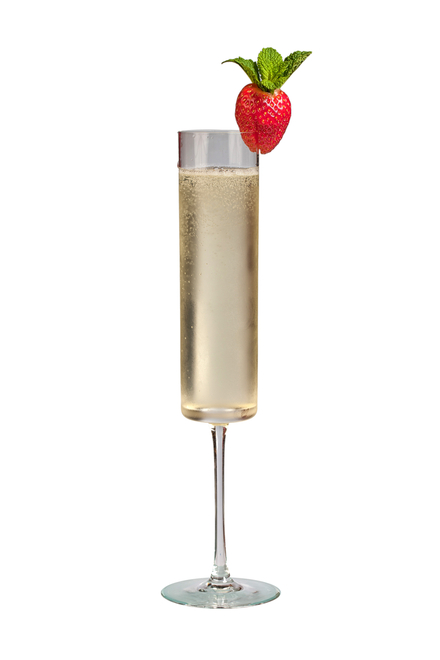

In [78]:
from PIL import Image
import requests
from io import BytesIO
drink = drink_list['Honey Bubble']
response = requests.get(drink['img'])
img = Image.open(BytesIO(response.content))

img

## GenSim

In [77]:
import gensim
import collections


In [272]:


docs = {drink: v['doc'] for drink, v in drink_list.items()}
doc_matrix = pd.Series(docs)
# Clean up bad entries
drop = []
drop.extend(doc_matrix[doc_matrix.str.contains('<p style=')].index)
drop.extend(doc_matrix[doc_matrix.str.contains('<w:latentst')].index)
drop.extend(doc_matrix[doc_matrix == ''].index)
doc_matrix = doc_matrix.drop(index=drop)


Absolut Pears Mule                   absolut pears mule pour absolut, ginger beer,...
Adults Only-Frozen Hot Chocolate     adults only-frozen hot chocolate in a blender...
Alabama Slammer                     this fruity and somewhat nutty flavored highba...
All American Lemonade                all american lemonade pour tito's handmade vo...
Amaretto Sour                       amaretto sours are sweet, slightly tart cockta...
dtype: object

### Read and preprocess text

In [234]:
def read_corpus(docs, tokens_only=False):
    for i, line in enumerate(docs):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [275]:
train_corpus = list(read_corpus(doc_matrix))

train_corpus[0]

TaggedDocument(words=['absolut', 'pears', 'mule', 'pour', 'absolut', 'ginger', 'beer', 'and', 'lime', 'juice', 'into', 'mule', 'mug', 'filled', 'with', 'ice', 'cubes', 'garnish', 'with', 'slice', 'of', 'pear', 'vodka', 'sweet', 'level', 'easy', 'prep', 'min', 'ice', 'cube', 'tray', 'swizzle', 'stick', 'citrus', 'juicer', 'we', 'didn', 'steer', 'you', 'wrong', 'on', 'the', 'whole', 'shorts', 'thing', 'trust', 'us', 'on', 'this', 'one', 'too', 'we', 'spent', 'over', 'year', 'to', 'achieve', 'the', 'ideal', 'balance', 'of', 'sweetness', 'and', 'spiciness', 'and', 'matching', 'it', 'to', 'the', 'flavour', 'profile', 'of', 'our', 'award', 'winning', 'black', 'seal', 'rum', 'only', 'our', 'black', 'seal', 'rum', 'makes', 'dark', 'stormy', 'genuine', 'only', 'our', 'ginger', 'beer', 'makes', 'it', 'perfect', 'extras', 'soda', 'water', 'soft', 'beverages', 'soda', 'sparkling', 'beverages', 'ginger', 'beer', 'introduced', 'in', 'absolut', 'pears', 'is', 'quite', 'newcomer', 'in', 'the', 'absolu

In [276]:
test_str = 'Gimme that hot and smokey'
test_corpus = list(read_corpus([test_str], tokens_only=True))

test_corpus

[['gimme', 'that', 'hot', 'and', 'smokey']]

### Instantiate and train doc2vec

In [308]:
def train_doc2vec(doc_matrix, vector_size, epochs, dm_mean):
    train_corpus = list(read_corpus(doc_matrix))

    %env PYTHONHASHSEED = 42
    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=2, epochs=epochs, seed=42, workers=1,
        dm_mean=1)

    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model, train_corpus

In [277]:
test = list(read_corpus([doc_matrix[0]], tokens_only=True))
model.random.seed(42)
model.infer_vector(test[0])

env: PYTHONHASHSEED=42


array([-0.8567703 , -0.2782822 ,  0.42307684, -0.25917163, -0.32960728,
        0.3324581 ,  0.18625145,  0.47892055,  0.762748  ,  0.50476766,
       -0.01597864, -0.01781018, -0.01269427, -0.15889852,  0.5427681 ,
       -0.31706232, -0.33946   ,  0.14076152,  0.5390483 , -0.5318779 ,
       -0.14008768,  0.20032643, -0.45127255,  0.07932486,  0.02063195,
        0.02159894, -0.074235  , -0.38805437, -0.5997104 , -0.07945058,
        0.22543313, -0.09974907,  0.5296266 ,  0.349981  ,  0.20381919,
       -0.6125682 , -0.586303  ,  0.25558907,  0.19700506,  0.02477785,
       -0.5465766 ,  0.24479295, -0.5444722 , -0.42527857,  0.5795907 ,
        0.37048897, -0.48855016,  0.18682455, -0.66177547,  0.2656388 ,
        0.02794432,  0.2110238 , -0.75452137,  0.07614438, -0.6626953 ,
        0.97294134, -0.12582585, -0.05020443,  0.2904951 ,  0.33594188,
       -0.05565991, -0.09230877, -0.71868974, -0.23000327, -0.06979813,
       -0.5405572 , -0.5677092 ,  0.17756405,  0.6711865 , -0.24

In [278]:
model.random.seed(42)
model.infer_vector(test_corpus[0])

array([-0.05820272,  0.08085015,  0.08136745, -0.03743922, -0.04217336,
        0.01272922,  0.05248077,  0.0232436 , -0.10632361, -0.0076478 ,
       -0.06544174, -0.00408522, -0.01042232,  0.03482882,  0.07721484,
        0.02085776, -0.05408046,  0.08715712,  0.07667477, -0.03353494,
       -0.0380678 , -0.03145054, -0.0753774 ,  0.00923934, -0.05559966,
       -0.0163561 ,  0.03472511, -0.09800036, -0.07667803, -0.00420319,
       -0.0475085 ,  0.04522036, -0.00868402,  0.05912237,  0.06683161,
        0.02431351, -0.11200941,  0.146299  , -0.07250509,  0.02513836,
       -0.0411526 ,  0.06025515,  0.01818377, -0.01509913,  0.04528969,
        0.00473424, -0.03163518,  0.0156024 , -0.01294681, -0.01376671,
        0.01321561, -0.06416685, -0.05842117, -0.01384989, -0.07712785,
        0.08282729,  0.00402295, -0.11260669, -0.00144383, -0.0057231 ,
       -0.09408729, -0.05911229,  0.00221654,  0.03782896,  0.00550659,
       -0.10099615,  0.00791434,  0.03552685,  0.07238428,  0.01

### Assessing model

In [279]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    model.random.seed(42)
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [285]:
doc_id = random.randint(0, len(train_corpus) - 1)
model.random.seed(42)
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

for i, sim in enumerate(sims):
    if sim[0] == doc_id:
        print(f'Doc {doc_id}, {doc_matrix.index[doc_id]} was ranked {i} with itself.\n')
        
print('Document ({}): «{}»\n'.format(doc_matrix.index[doc_id], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)

for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 5)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Doc 232, Glen Groni was ranked 1 with itself.

Document (Glen Groni): «glen groni shake all ingredients except club soda or sparkling wine with ice for ten seconds strain into cocktail glass top with club soda or sparkling wine scotch brunch level easy prep min highball glass jigger shaker since canada dry has been known for producing quality beverages and mixers canada dry club soda offers clean sparkling taste and it the perfect addition to your favorite cocktail it can also be enjoyed on its own for unique refreshing carbonated beverage alternative that contains zero calories and is caffeine free enjoy refreshing taste of bubbly effervescence with canada dry club soda extras soda water soft beverages soda sparkling beverages club soda for over years campari has been favorite liqueur for drinkers with different tastes the liquid is dark red color and is often mixed with other alcohols and non alcoholic drinks for cocktails the drink was created in depending on where the campari is so

In [95]:
%env PYTHONHASHSEED = 42

def read_corpus(docs, tokens_only=False):
    for i, line in enumerate(docs):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])
            
            
def train_doc2vec(doc_matrix, vector_size, epochs):
    train_corpus = list(read_corpus(doc_matrix))

    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=2, epochs=epochs, seed=42, workers=1,
        dm_mean=1)

    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model, train_corpus


def measure_steps(train_corpus, model, s):
    ranks = []
    for doc_id in range(len(train_corpus)):
        inferred_vector = model.infer_vector(train_corpus[doc_id].words, steps=s)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

        for i, sim in enumerate(sims):
            if sim[0] == doc_id:
                ranks.append(i + 1)
    ranks = pd.Series(ranks)
    score = ranks.mean()
    return score


@load_or_make('../models/model_record.pkl', overwrite='n')
def get_record():
    cols = ['score', 'vector_size', 'epochs', 'steps']
    record = pd.DataFrame(columns=cols)
    return record


def plot_grid_search(record):
    for p in ['vector_size', 'epochs', 'steps']:
        plt.figure()
        sns.scatterplot(x=p, y='score', data=record[record['score'] < 20]);
    pass


def grid_search(doc_matrix, vectors=[125], epochs=[20], steps=[3]):
    """
    Performs a grid search to find optimal parameters for doc2vec model.
    Instantiated with values previously found to be optimal; should be updated
    if corpus changes significantly.
    Input:
        doc_matrix, an array of cleaned documents ready to be tokenized
        vectors, epochs, and steps are all iterables containing the different
            parameter permutations to try in the grid search
    Output: record of all model iterations
    """
    record = get_record()
    for v in vectors:
        for e in epochs:
            model, train_corpus = train_doc2vec(
                doc_matrix, vector_size=v, epochs=e)
            for s in steps:
                score = measure_steps(train_corpus, model, s)
                results = [score, v, e, s]
                print(results)
                record.loc[len(record)] = results
    save_to(record, '../models/model_record.pkl')
    display(record.sort_values(by='score').head(10))
    plot_grid_search(record)
    return record

env: PYTHONHASHSEED=42


## Grid Search

Loaded file from ../data/processed/doc_matrix.pkl
[24.09844433641225, 75, 100, 3]
[11.198590179873602, 75, 200, 3]
[6.063198833252309, 75, 400, 3]
[15.344676713660672, 150, 100, 3]
[10.653378706854642, 150, 200, 3]
[8.054691298006807, 150, 400, 3]
[15.783665532328634, 300, 100, 3]
[12.22824501701507, 300, 200, 3]
[10.527953330092368, 300, 400, 3]
Saved file to ../models/model_record.pkl


,score,vector_size,epochs,steps
49,6.063199,75.0,400.0,3.0
52,8.054691,150.0,400.0,3.0
55,10.527953,300.0,400.0,3.0
51,10.653379,150.0,200.0,3.0
48,11.198590,75.0,200.0,3.0
54,12.228245,300.0,200.0,3.0
44,13.344434,200.0,160.0,3.0
46,14.062227,400.0,160.0,3.0
50,15.344677,150.0,100.0,3.0
53,15.783666,300.0,100.0,3.0


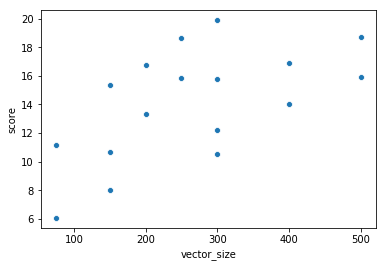

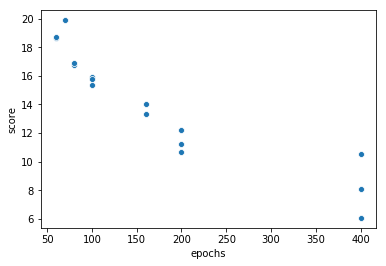

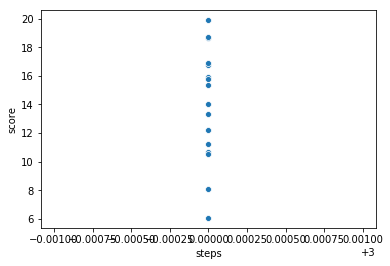

In [96]:
doc_matrix = load_from('../data/processed/doc_matrix.pkl')
vectors = [75, 150, 300]
epochs = [100, 200, 400]
steps = [3]
grid_search(doc_matrix, vectors, epochs, steps);

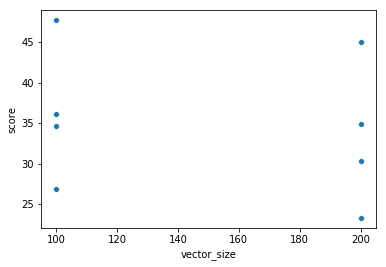

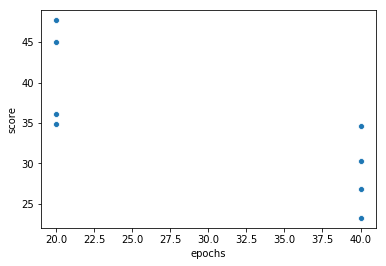

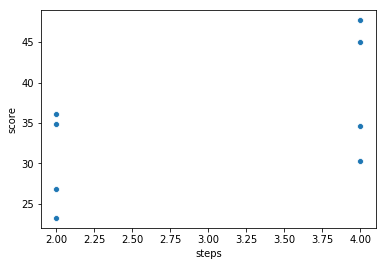

In [91]:
record = get_record()
plot_grid_search(record)

## Model Parameters

In [384]:
vector_size = 125
epochs = 21
steps = 3

In [385]:
model, train_corpus = train_doc2vec(
            doc_matrix, vector_size=125, epochs=21, dm_mean=1)


In [386]:
doc_id = random.randint(0, len(train_corpus) - 1)
model.random.seed(42)
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

for i, sim in enumerate(sims):
    if sim[0] == doc_id:
        print(f'Doc {doc_id}, {doc_matrix.index[doc_id]} was ranked {i} with itself.\n')
        
print('Document ({}): «{}»\n'.format(doc_matrix.index[doc_id], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)

for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 5)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Doc 272, Hornitos® Margarita was ranked 0 with itself.

Document (Hornitos® Margarita): «hornitos margarita combine all ingredients in shaker strain into margarita glass garnish with lime wedge and serve salt rim optional tequila margarita level easy prep min hawthorne strainer knife margarita glass jigger for smooth tasting tequila made from blue agave look no further than hornitos plata tequila enjoyable start to finish this pure delivery of true agave flavor benefits from hornitos unique cultivation and distillation process with floral and herbal aroma with fruity citrus notes this agave forward tequila has slight citrus note with medium bodied briefly warm and smooth and dry finish savor this expertly crafted tequila on its own or in cocktails like the paloma allowing its clean and fresh character to shine through liquor tequila silver blanco tequila extras mixers syrups bitters syrups sweeteners agave syrup»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d125,n5,w5,mc2,s0.001):



In [398]:
docid = 0
test_str = input()
test_corpus = list(read_corpus([test_str], tokens_only=True))
model.random.seed(42)
inferred_vector = model.infer_vector(test_corpus[0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print(u'Most Similar/Dissimilar Cocktails:\n')

for label, index in [('MOST', 0), ('LEAST', len(sims) - 5)]:
    print(f"{label} -- {doc_matrix.index[sims[index][0]]}:\n {' '.join(train_corpus[sims[index][0]].words)}\n")

I want something sweet and smokey, maybe with Mezcal, benedictine, chartreuse and possibly honey? And garnished with a cherry!
want something sweet and smokey maybe with mezcal benedictine chartreuse and possibly honey and garnished with cherry
Most Similar/Dissimilar Cocktails:

MOST -- UV Cran Razzle:
 razzle dazzle your taste buds with this super swift nice and easy incredibly tasty cocktail nbsp uv cran razzle combine ingredients in lowball glass stir and enjoy vodka level easy prep min lowball glass bar spoon jigger enjoy the crisp clean taste of real cranberries straight from the bog it delicious way to get your daily dose of vitamin and unique cranberry health benefits extras soda water soft beverages juice cranberry juice expected is boring which is the opposite of uv blue naturally flavored with vine ripened raspberries uv blue adds touch of sudden sweetness to any situation try it with lemonade lemon lime soda or almost any other mixer liquor vodka flavored vodka
LEAST -- Smi

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [79]:
## %%writefile ../src/visualization/visualize.py

# Imports
from itertools import cycle
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import hvplot.pandas

import nltk
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Parameters
int_drink_path = '../data/interim/drink_list.pickle'
doc_matrix_path = '../data/processed/doc_matrix.pkl'
proc_data_path = '../data/processed/dt_matrix.pickle'
vectorizer_path = '../models/vectorizer.pkl'
X_topics_path = '../data/processed/X_topics.pkl'


# Helper functions go here

# Doc2Vec
%env PYTHONHASHSEED = 42

def read_corpus(docs, tokens_only=False):
    for i, line in enumerate(docs):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])
            
            
def train_doc2vec(doc_matrix, vector_size, epochs, dm_mean):
    train_corpus = list(read_corpus(doc_matrix))

    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=2, epochs=epochs, seed=42, workers=1,
        dm_mean=1)

    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model, train_corpus


def measure_steps(train_corpus, model, s):
    ranks = []
    for doc_id in range(len(train_corpus)):
        inferred_vector = model.infer_vector(train_corpus[doc_id].words, steps=s)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

        for i, sim in enumerate(sims):
            if sim[0] == doc_id:
                ranks.append(i + 1)
    ranks = pd.Series(ranks)
    score = ranks.mean()
    return score


@load_or_make('../models/model_record.pkl', overwrite='n')
def get_record():
    cols = ['score', 'vector_size', 'epochs', 'steps']
    record = pd.DataFrame(columns=cols)
    return record


def plot_grid_search(record):
    for p in ['vector_size', 'epochs', 'steps']:
        plt.figure()
        sns.scatterplot(x=p, y='score', data=record[record['score'] < 2]);
    pass


def grid_search(doc_matrix, vectors=[125], epochs=[20], steps=[3]):
    """
    Performs a grid search to find optimal parameters for doc2vec model.
    Instantiated with values previously found to be optimal; should be updated
    if corpus changes significantly.
    Input:
        doc_matrix, an array of cleaned documents ready to be tokenized
        vectors, epochs, and steps are all iterables containing the different
            parameter permutations to try in the grid search
    Output: record of all model iterations
    """
    record = get_record()
    for v in vectors:
        for e in epochs:
            model, train_corpus = train_doc2vec(
                doc_matrix, vector_size=v, epochs=e)
            for s in steps:
                score = measure_steps(train_corpus, model, s)
                results = [score, v, e, s]
                print(results)
                record.loc[len(record)] = results
    save_to(record, '../models/model_record.pkl')
    display(record.sort_values(by='score').head(10))
    plot_grid_search(record)
    return record

# TF-IDF
def visualize_topics(X, y, suggested):
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(X)
    
#     print('X TSNE')
    X_2D = pd.DataFrame(X_2D, index=X.index).reset_index()
    X_2D.columns = ['Cocktail', 'Topic 1', 'Topic 2', ]
#     display(X_2D.head())
    
#     print('Y_TSNE')
    y_2D = X_2D[X_2D['Cocktail'] == suggested]

    # Make plot
    p = X_2D.hvplot(x='Topic 1', y='Topic 2', 
                    hover_cols=['Cocktail'], kind='scatter',
                    width=800, height=800) * \
        y_2D.hvplot(x='Topic 1', y='Topic 2', 
                    hover_cols=['Cocktail'], kind='scatter')
    display(p)
    pass
    

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if ix > 4:
            break
        if not topic_names or not topic_names[ix]:
            print("\nCategory ", ix + 1)
        else:
            print("\nCategory: '", topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    pass


def predict(testing=0):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    vectorizer = load_from(vectorizer_path, verbose=False)
    svd = load_from('../models/svd.pkl', verbose=False)
    X_topics = load_from(X_topics_path, verbose=False)
    
    display_topics(svd, vectorizer.get_feature_names(), 5)
    
    if testing:
        actual = 'Kamikazi'
#         print(f'***TESTING: This request should yield a "{actual}"')
        print('\nHow would you like your drink?\n')
        request = 'A mezcal based Manhattan variation with a bitter amaro'
#         request = "When this shooter is done right no chaser is required. Dating back to the days of disco, the Kamikaze shooter allowed for the best kind of saturday night fever. Kamikaze Combine vodka, triple sec, and lime juice in a shaker over ice; shake vigorously for 10-15 seconds. Strain into a rocks glass or into two shot glasses vodka shot liqueur Level: Easy Prep: 2 min Jigger Shot glass Cointreau, the crystal clear Orange Liqueur, founded in Angers, France, remains one of the world's most distinguished spirits with over 160 years of history. \n\n\nRenowned for its perfect balance of sweet and bitter orange peels and made with only the finest all-natural ingredients, Cointreau has a uniquely refreshing and complex taste. A versatile, 80 proof spirit, Cointreau can be enjoyed as the base spirit in many cocktails, such as the Cointreau Rickey, but is also an essential ingredient in the most popular cocktails including the Margarita, the Cosmopolitan, and the Sidecar. Liquor Liqueur, Cordials, & Schnapps Fruit Liqueur Rose's lime juice, often known simply as Rose's, is a concentrated fruit juice patented in 1867. This makes it the world's first concentrated bottled fruit juice drink. Extras Mixers, Syrups, & Bitters Bar Mixers"
        print(request)
    else:
        request = input('\nHow would you like your drink?\n')
    
    y_doc = clean_document(request)
    y_doc_vec = vectorizer.transform([y_doc])
    y_topic = svd.transform(y_doc_vec)
    
    cosine_sims = cosine_similarity(X_topics, y_topic).flatten()
    cos_sims_sorted = pd.Series(
        cosine_sims, 
        index=X_topics.index,
        name='Cosine Similarity'
    ).sort_values(ascending=False)
    suggested_cocktail = cos_sims_sorted.index[0]

    print('\nMost Similar Cocktails:')
    display(cos_sims_sorted.head())
    
    # TSNE
    visualize_topics(X_topics, y_topic, suggested_cocktail)
    
    return suggested_cocktail


def plot_2D(data, target, target_names):
#     colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()
    pass


def make_exp_var_plot(method):
    exp_var_ratio = method.explained_variance_ratio_
    
    plt.plot(np.cumsum(exp_var_ratio))
    plt.xlabel('# components')
    plt.ylabel('Cumulative explained variance');
    plt.title('Cumulative explained variance by method');
    return


def get_topics(dt_matrix, num_topics):
    
    lsa = TruncatedSVD(num_topics)
    X_topics = lsa.fit_transform(dt_matrix)
    X_topics = pd.DataFrame(X_topics, index=dt_matrix.index)

    save_to(X_topics, X_topics_path, verbose=False)
    
    expl_var = lsa.explained_variance_ratio_
    topic_word = pd.DataFrame(lsa.components_.round(3),
                 columns = dt_matrix.columns)
    return lsa


# @load_or_make(proc_data_path, overwrite='y')
def get_doc_term_matrix(doc_matrix):
    """
    Takes in doc matrix and converts to doc term matrix with TF-IDF vectorier
    """
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2)
    )
    
    doc_vectors = vectorizer.fit_transform(doc_matrix)
#     display(pd.DataFrame(doc_vectors))
    save_to(vectorizer, vectorizer_path, verbose=False)

    dt_matrix = pd.DataFrame(
        doc_vectors.toarray(), 
        index=doc_matrix.index, 
        columns=vectorizer.get_feature_names()
    )
#     print('Doc-term matrix: cocktails and vocabulary')
#     display(dt_matrix.head())
    
    return dt_matrix


@load_or_make(doc_matrix_path, overwrite='n')
def get_doc_matrix(drink_list):
    docs = {drink: v['doc'] for drink, v in drink_list.items()}
    doc_matrix = pd.Series(docs)
    
    # Clean up bad data (this should really move to Scrub)
    drop = []
    drop.extend(doc_matrix[doc_matrix.str.contains('<p style=')].index)
    drop.extend(doc_matrix[doc_matrix.str.contains('<w:latentst')].index)
    drop.extend(doc_matrix[doc_matrix == ''].index)
    drop.extend(doc_matrix[doc_matrix.isna()])

    doc_matrix = doc_matrix.drop(index=drop)
    return doc_matrix
    
    
def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    num_components = 1000
    drink_list = load_from(int_drink_path, verbose=False)
    doc_matrix = get_doc_matrix(drink_list)
    
    #TF-IDF
    dt_matrix = get_doc_term_matrix(doc_matrix)
    svd = get_topics(dt_matrix, num_components)
    
    make_exp_var_plot(svd)
    save_to(svd, '../models/svd.pkl', verbose=False)
    
    drink_prediction = predict(testing=1)
    print(f"I'll make you a {drink_prediction}")
    drink = drink_list[drink_prediction]
    
    recipe = drink['recipe']
    print(f'\nThe recipe for that is:')
    if type(recipe) == list:
        for line in recipe:
            print('\t', line.replace('\n', ' ').replace('\xa0', ' '))
    if type(recipe) == pd.core.frame.DataFrame:
        display(recipe)
    
    url = drink['url']
    print(f'\nThis cocktail came from:\n{url}')
    
    img_url = drink['img']
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    display(img)
    
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    return dt_matrix


env: PYTHONHASHSEED=42



Category  1
glass, ingredients, ice, juice, liqueur

Category  2
vermouth, dry, martini, dry vermouth, noilly

Category  3
rum, bacardi, carta, bacardi carta, superior

Category  4
tequila, agave, cream, patron, 100 agave

Category  5
half, cream, scotch, apple, whisky

How would you like your drink?

I want something sweet, smokey, savory and probably up to no good. Maybe a mezcal base, salt and honey?

Most Similar Cocktails:


Tequila Sunset          0.371762
Thomas Blood Martini    0.340112
The Hive                0.340010
Honey Bubble            0.339778
Aged Honey Daiquiri     0.322662
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Tequila Sunset

The recipe for that is:


,Qty,Units,Ingredient
1,7,spoon,Runny honey
2,2,fl oz,Patrón Reposado (orange seal) 100% agave tequila
3,2,fl oz,Freshly squeezed lemon juice



This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/1936/tequila-sunset


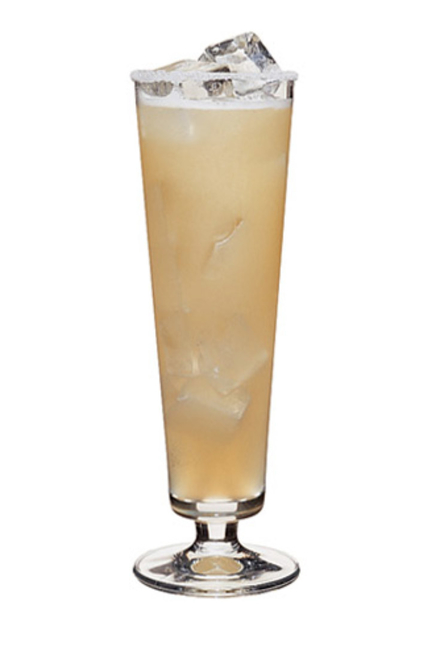

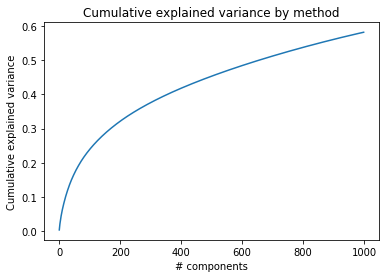

In [80]:
dt_matrix = run()


In [81]:
dt_matrix.head()

,000,000 acre,000 entries,000 sold,05,05 wonderfully,0824,0824 glass,10,10 50,...,zuzu,zuzu petals,zygomates,zygomates boston,øines,øines rom,østersø,østersø cola,πρεσβυτερος,πρεσβυτερος greek
'75' Cocktail (Vermeire's 1922 recipe),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Two Guns' Miller,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18th Century Cocktail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1920s Artist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
d_matrix.index

Index([''75' Cocktail (Vermeire's 1922 recipe)', ''Two Guns' Miller', '1862',
       '18th Century Cocktail', '1920s Artist', '20th Century Cocktail',
       '49th Parallel', '57 T-Bird Shot',
       '75 Cocktail (MacElhone's 1926 recipe)', '8th Day (Non-alcoholic)',
       ...
       'Woodford Reserve Neat', 'Woodford Reserve Old Fashioned', '1-2 Punch',
       '1920 Highball', '19° North', '7UP Orange Spice Punch',
       '7UP Pom Spritzer', '7UP Side Down Cocktail', '7UP Winter Mint Punch',
       '7UP Pineapple Rum Float'],
      dtype='object', length=4772)

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [ ]:
## %%writefile ../src/models/train_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    request = input('How would you like your drink?')
    svd = load_from('../models/svd.pkl')
    
    svd.predict()
    
    predict with method
    cosine similarity against all cocktails
    select and return max
    # data = load_features('data/processed/')
    # train, test = train_test_split(data)
    # save_train_test(train, test, 'data/processed/')
    # model = build_model()
    # model.fit(train)
    # save_model(model, 'models/')
    pass


In [ ]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    
    # test_X, test_y = load_test_data('data/processed')
    # trained_model = load_model('models/')
    # predictions = trained_model.predict(test_X)
    # metrics = evaluate(test_y, predictions)
    # save_metrics('reports/')
    pass



_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_

# Universal Helpers

In [1]:
import os
import pickle

def load_or_make(filepath, overwrite='n'):
    def decorator(func):
        def wraps(*args, **kwargs):
            if overwrite == 'y':
                ow = input(f'Are you sure you want to overwrite {filepath}? y/n: ')
                if (os.path.exists(filepath)) and (ow == 'y'):
                    os.remove(filepath)
            try:
                with open(filepath, 'rb') as f:
                    data = pickle.load(f)
            except:
                data = func(*args, **kwargs)
                with open(filepath, 'wb') as to_write:
                    pickle.dump(data, to_write)
            return data
        return wraps
    return decorator


def save_to(item, filepath, verbose=True):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write)
    if verbose:
        print(f'Saved file to {filepath}')
    return


def load_from(filepath, verbose=True):
    """
    Unpickles item and returns item from path
    Input: filepath to pickled object
    Output: unpickled object
    """
    if not file_exists(filepath):
        print(f'Failed to load from {filepath}. Does not exist.')
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    if verbose:
        print(f'Loaded file from {filepath}')
    return item


def file_exists(filepath):
    """
    Returns True if specified file already exists, else False
    Input:
        path (str), path to directory containing file
        filename (str), name of file to check for
    Output: True if specified file already exists, else False
    """
    file_exists = os.path.isfile(filepath)
    return file_exists

